In [ ]:
import os
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras import models, layers, regularizers, metrics, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG19
from scipy import stats
import shutil
import random
from sklearn.metrics import confusion_matrix

In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"meleknuryazlamaz","key":"acce121da2a36af92485fa9f692d92f8"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d tourist55/alzheimers-dataset-4-class-of-images

 26% 9.00M/34.1M [00:00<00:01, 24.9MB/s]
100% 34.1M/34.1M [00:00<00:00, 63.4MB/s]


In [ ]:
! mkdir Alzheimer-MRI
! unzip alzheimers-dataset-4-class-of-images.zip -d Alzheimer-MRI

Görüntülenen çıkış son 5000 satıra kısaltıldı.
  inflating: Alzheimer-MRI/Alzheimer_s Dataset/train/MildDemented/mildDem207.jpg  
  inflating: Alzheimer-MRI/Alzheimer_s Dataset/train/MildDemented/mildDem208.jpg  
  inflating: Alzheimer-MRI/Alzheimer_s Dataset/train/MildDemented/mildDem209.jpg  
  inflating: Alzheimer-MRI/Alzheimer_s Dataset/train/MildDemented/mildDem21.jpg  
  inflating: Alzheimer-MRI/Alzheimer_s Dataset/train/MildDemented/mildDem210.jpg  
  inflating: Alzheimer-MRI/Alzheimer_s Dataset/train/MildDemented/mildDem211.jpg  
  inflating: Alzheimer-MRI/Alzheimer_s Dataset/train/MildDemented/mildDem212.jpg  
  inflating: Alzheimer-MRI/Alzheimer_s Dataset/train/MildDemented/mildDem213.jpg  
  inflating: Alzheimer-MRI/Alzheimer_s Dataset/train/MildDemented/mildDem214.jpg  
  inflating: Alzheimer-MRI/Alzheimer_s Dataset/train/MildDemented/mildDem215.jpg  
  inflating: Alzheimer-MRI/Alzheimer_s Dataset/train/MildDemented/mildDem216.jpg  
  inflating: Alzheimer-MRI/Alzheimer_s Da

In [ ]:
training_path       =  "Alzheimer-MRI/Alzheimer_s Dataset/train/"
test_path           =  "Alzheimer-MRI/Alzheimer_s Dataset/test/"

validation_split               = 0.20
regression_problem             = False
target_img_shape_1             = 224
target_img_shape_2             = 224
target_img_channels            = 3
conv_layers                    = 4
conv_filters                   = [32,64,128,128]
conv_filter_shape              = [[3,3]]*conv_layers
conv_activation_function       = ['relu']*conv_layers
conv_padding                   = ['valid']*conv_layers
conv_pooling_type              = ['max']*conv_layers
conv_pooling_shape             = [[2,2]]*conv_layers
augment_data                   = True
rotation_range                 = 0.1
width_shift_range              = 0.1
height_shift_range             = 0.1
shear_range                    = 0.1
brightness_range               = [0.8,1.2]
zoom_range                     = 0.1
horizontal_flip                = False
fill_mode                      = 'nearest'
print_sample_input             = True
hidden_activation_function     = ['relu']
hidden_layers_neurons          = [128]
hidden_layers_L1_coeffs        = [0.00]
hidden_layers_L2_coeffs        = [0.00]
hidden_layers_dropout          = [0.00]
final_activation_function      = 'softmax'
final_layer_neurons            = 4
model_optimizer                = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
loss_function                  = 'categorical_crossentropy'
metrics                        = [metrics.CategoricalAccuracy(name='categorical_accuracy'),
                                  metrics.AUC(multi_label = True, name='multiclass_AUC')]
n_epochs                       = 40
batch_size                     = 40
validation_steps               = 50
vgg_include_top                = False
vgg_hidden_activation_function = ['relu']
vgg_hidden_layers_neurons      = [128]
vgg_hidden_layers_L1_coeffs    = [0.00]
vgg_hidden_layers_L2_coeffs    = [0.00]
vgg_hidden_layers_dropout      = [0.00]
vgg_final_activation_function  = 'softmax'
vgg_final_layer_neurons        = 4
vgg_model_optimizer            = optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
vgg_n_epochs                   = 40
vgg_validation_steps           = 50

In [ ]:
newlabels              = ['MildDemented','ModerateDemented','NonDemented', 'VeryMildDemented']
_training_path   = "Alzheimer-MRI/Alzheimer_s Dataset/training_set/"
new_validation_path = "Alzheimer-MRI/Alzheimer_s Dataset/validation_set/"
new_test_path       = "Alzheimer-MRI/Alzheimer_s Dataset/test_set/"
shutil.rmtree(new_training_path, ignore_errors=True)
shutil.rmtree(new_validation_path, ignore_errors=True)
shutil.rmtree(new_test_path, ignore_errors=True)
[os.makedirs(new_training_path + label,exist_ok=True) for label in labels]
[os.makedirs(new_validation_path + label,exist_ok=True) for label in labels]
[os.makedirs(new_test_path + label,exist_ok=True) for label in labels]
training_label_frequencies   = []
for label in labels:
        training_filenames   = os.listdir(training_path + label + "/")
        validation_filenames = random.sample(training_filenames, int(len(training_filenames)*validation_split))
        training_filenames   = [file for file in training_filenames if file not in validation_filenames]
        test_filenames       = os.listdir(test_path + label + "/")
        for file in training_filenames:
            shutil.copy(training_path + label + "/" + file, new_training_path + label + "/" + file)
        print('Training images transfer complete for label: ' + label + '. # transferred images: ' + str(len(training_filenames)))
        for file in validation_filenames:
            shutil.copy(training_path + label + "/" + file, new_validation_path + label + "/" + file)
        print('Validation images transfer complete for label: ' + label + '. # transferred images: '  + str(len(validation_filenames)))
        for file in test_filenames:
            shutil.copy(test_path + label + "/" + file, new_test_path + label + "/" + file)
        print('Test images transfer complete for label: ' + label + '. # transferred images: '  + str(len(test_filenames)))

        training_label_frequencies.append(len(training_filenames))

Training images transfer complete for label: MildDemented. # transferred images: 574
Validation images transfer complete for label: MildDemented. # transferred images: 143
Test images transfer complete for label: MildDemented. # transferred images: 179
Training images transfer complete for label: ModerateDemented. # transferred images: 42
Validation images transfer complete for label: ModerateDemented. # transferred images: 10
Test images transfer complete for label: ModerateDemented. # transferred images: 12
Training images transfer complete for label: NonDemented. # transferred images: 2048
Validation images transfer complete for label: NonDemented. # transferred images: 512
Test images transfer complete for label: NonDemented. # transferred images: 640
Training images transfer complete for label: VeryMildDemented. # transferred images: 1434
Validation images transfer complete for label: VeryMildDemented. # transferred images: 358
Test images transfer complete for label: VeryMildDeme

In [ ]:
training_label_frequencies = np.array(training_label_frequencies)
target_n_samples           = np.max(training_label_frequencies)
for i in range(len(labels)):
    current_label     = labels[i]
    n_missing_samples = target_n_samples - training_label_frequencies[i]
    filenames         = os.listdir(new_training_path + current_label + "/")
    n_filled          = np.zeros(len(filenames))
    while (np.sum(n_filled) < n_missing_samples):
          idx = np.random.randint(0,len(filenames))
          shutil.copy(new_training_path + current_label + "/" + filenames[idx], new_training_path + current_label + "/" + filenames[idx].replace(".jpg", "_copy_" + str(int(n_filled[idx] + 1)) + ".jpg"))
          n_filled[idx] += 1




In [ ]:
if augment_data:
    train_datagen   = ImageDataGenerator(rescale            = 1./255,
                                         rotation_range     = rotation_range,
                                         width_shift_range  = width_shift_range,
                                         height_shift_range = height_shift_range,
                                         shear_range        = shear_range,
                                         brightness_range   = brightness_range,
                                         zoom_range         = zoom_range,
                                         horizontal_flip    = horizontal_flip,
                                         fill_mode          = fill_mode)
else:
    train_datagen   = ImageDataGenerator(rescale = 1./255)

validation_datagen   = ImageDataGenerator(rescale = 1./255)
test_datagen         = ImageDataGenerator(rescale = 1./255)
train_generator      = train_datagen.flow_from_directory(new_training_path,target_size = (target_img_shape_1, target_img_shape_2), batch_size = batch_size, class_mode = "categorical")
validation_generator = validation_datagen.flow_from_directory(new_validation_path,target_size = (target_img_shape_1, target_img_shape_2), batch_size = batch_size, class_mode = "categorical")
test_generator       = test_datagen.flow_from_directory(new_test_path,target_size = (target_img_shape_1, target_img_shape_2), batch_size = batch_size, class_mode = "categorical")

Found 8192 images belonging to 4 classes.
Found 1023 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.


In [ ]:
def dataset_basic_info(generator, name):
        print('The ' + name + ' data set includes ' + str(generator.samples) + ' samples.')
        print('The ' + name + ' image shapes is ' + str(generator.image_shape))
        keys = [el for el in generator.class_indices.keys()]
        print('The ' + name + ' data set includes the following labels: ')
        print(keys)
        labels     = generator.labels
        cat_labels = []
        for i in range(len(labels)):
            for j in range(len(keys)):
                if (labels[i] == j):
                    cat_labels.append(keys[j])
                    break
        occurrences = []
        for key in keys:
            counter = 0
            for i in range(len(cat_labels)):
                if cat_labels[i] == key:
                    counter += 1
            occurrences.append(counter)
        print(name + ' data set labels frequencies:')
        weights = {}
        for i in range(len(keys)):
            print(keys[i] + ': ' + str(occurrences[i]) + ' (absolute), ' + str(round(occurrences[i]/float(generator.samples), 3)) + ' (relative).' )
            weights[i] = generator.samples/np.array(occurrences[i])*(1.0/float(len(keys)))

        return weights

In [ ]:
train_labels_weights_dict      = dataset_basic_info(train_generator, 'training')
validation_labels_weights_dict = dataset_basic_info(validation_generator, 'validation')
test_labels_weights_dict       = dataset_basic_info(test_generator, 'test')

The training data set includes 8192 samples.
The training image shapes is (224, 224, 3)
The training data set includes the following labels: 
['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']
training data set labels frequencies:
MildDemented: 2048 (absolute), 0.25 (relative).
ModerateDemented: 2048 (absolute), 0.25 (relative).
NonDemented: 2048 (absolute), 0.25 (relative).
VeryMildDemented: 2048 (absolute), 0.25 (relative).
The validation data set includes 1023 samples.
The validation image shapes is (224, 224, 3)
The validation data set includes the following labels: 
['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']
validation data set labels frequencies:
MildDemented: 143 (absolute), 0.14 (relative).
ModerateDemented: 10 (absolute), 0.01 (relative).
NonDemented: 512 (absolute), 0.5 (relative).
VeryMildDemented: 358 (absolute), 0.35 (relative).
The test data set includes 1279 samples.
The test image shapes is (224, 224, 3)
The test data se

In [ ]:
def display_input_images(generator, max_n_figures, batch_size, grid_size, fig_size):

    fig_counter = 0
    for image_batch, label_batch in generator:
        plt.figure(figsize=(fig_size[0],fig_size[1]))
        for j in range(batch_size):
            ax   = plt.subplot(grid_size[0], grid_size[1], j + 1)
            plt.imshow(image_batch[j])
            if (label_batch[j][0] == 1):
                    plt.title('MildDemented')
            elif (label_batch[j][1] == 1):
                    plt.title('ModerateDemented')
            elif (label_batch[j][2] == 1):
                    plt.title('NonDemented')
            else:
                    plt.title('VeryMildDemented')
            plt.axis("off")
        plt.show()
        fig_counter += 1
        if (fig_counter == max_n_figures): break

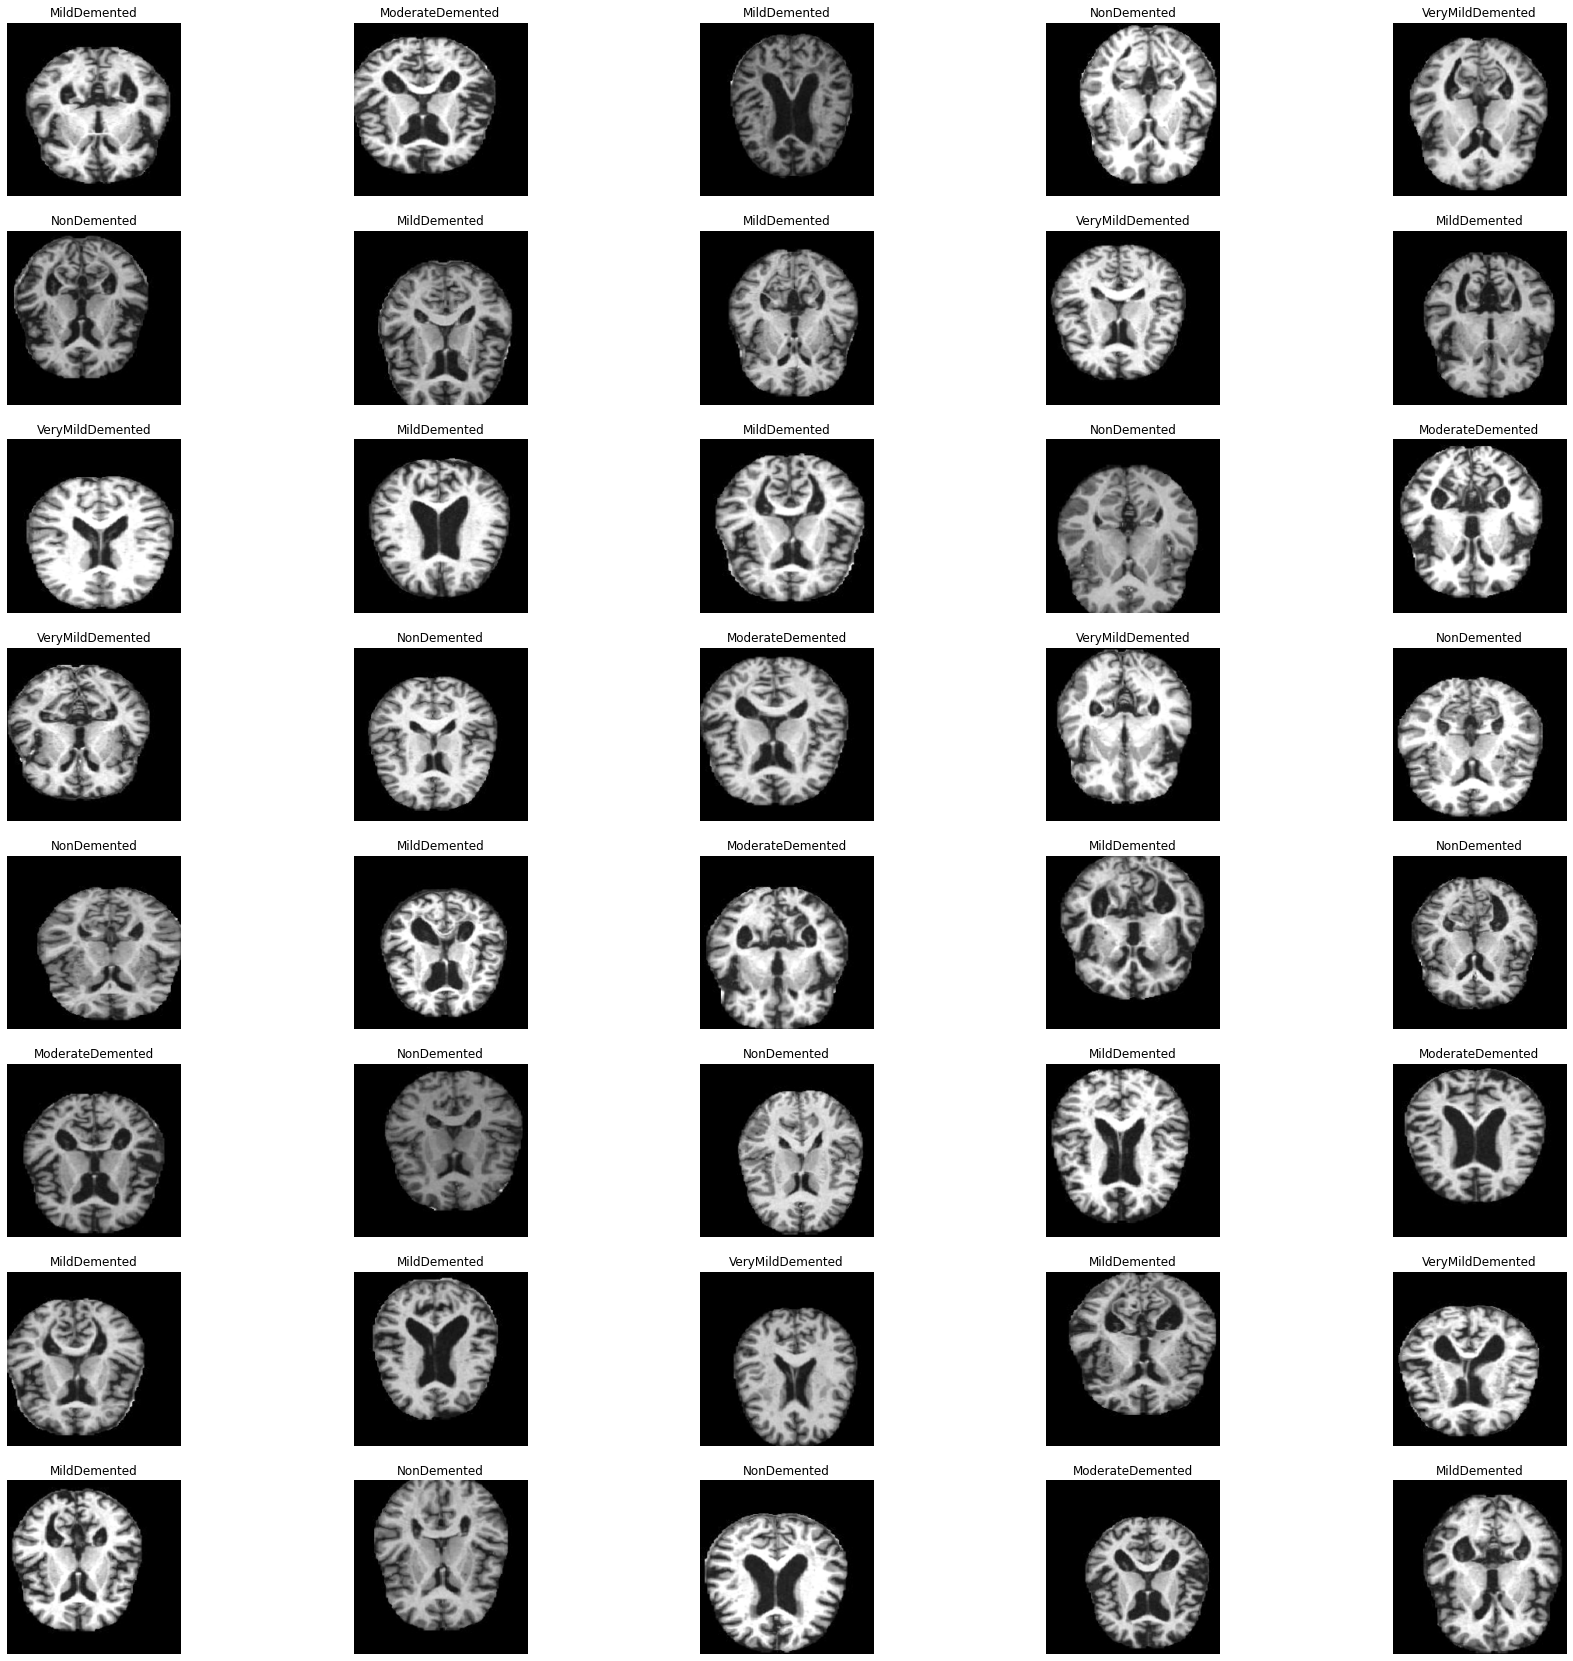

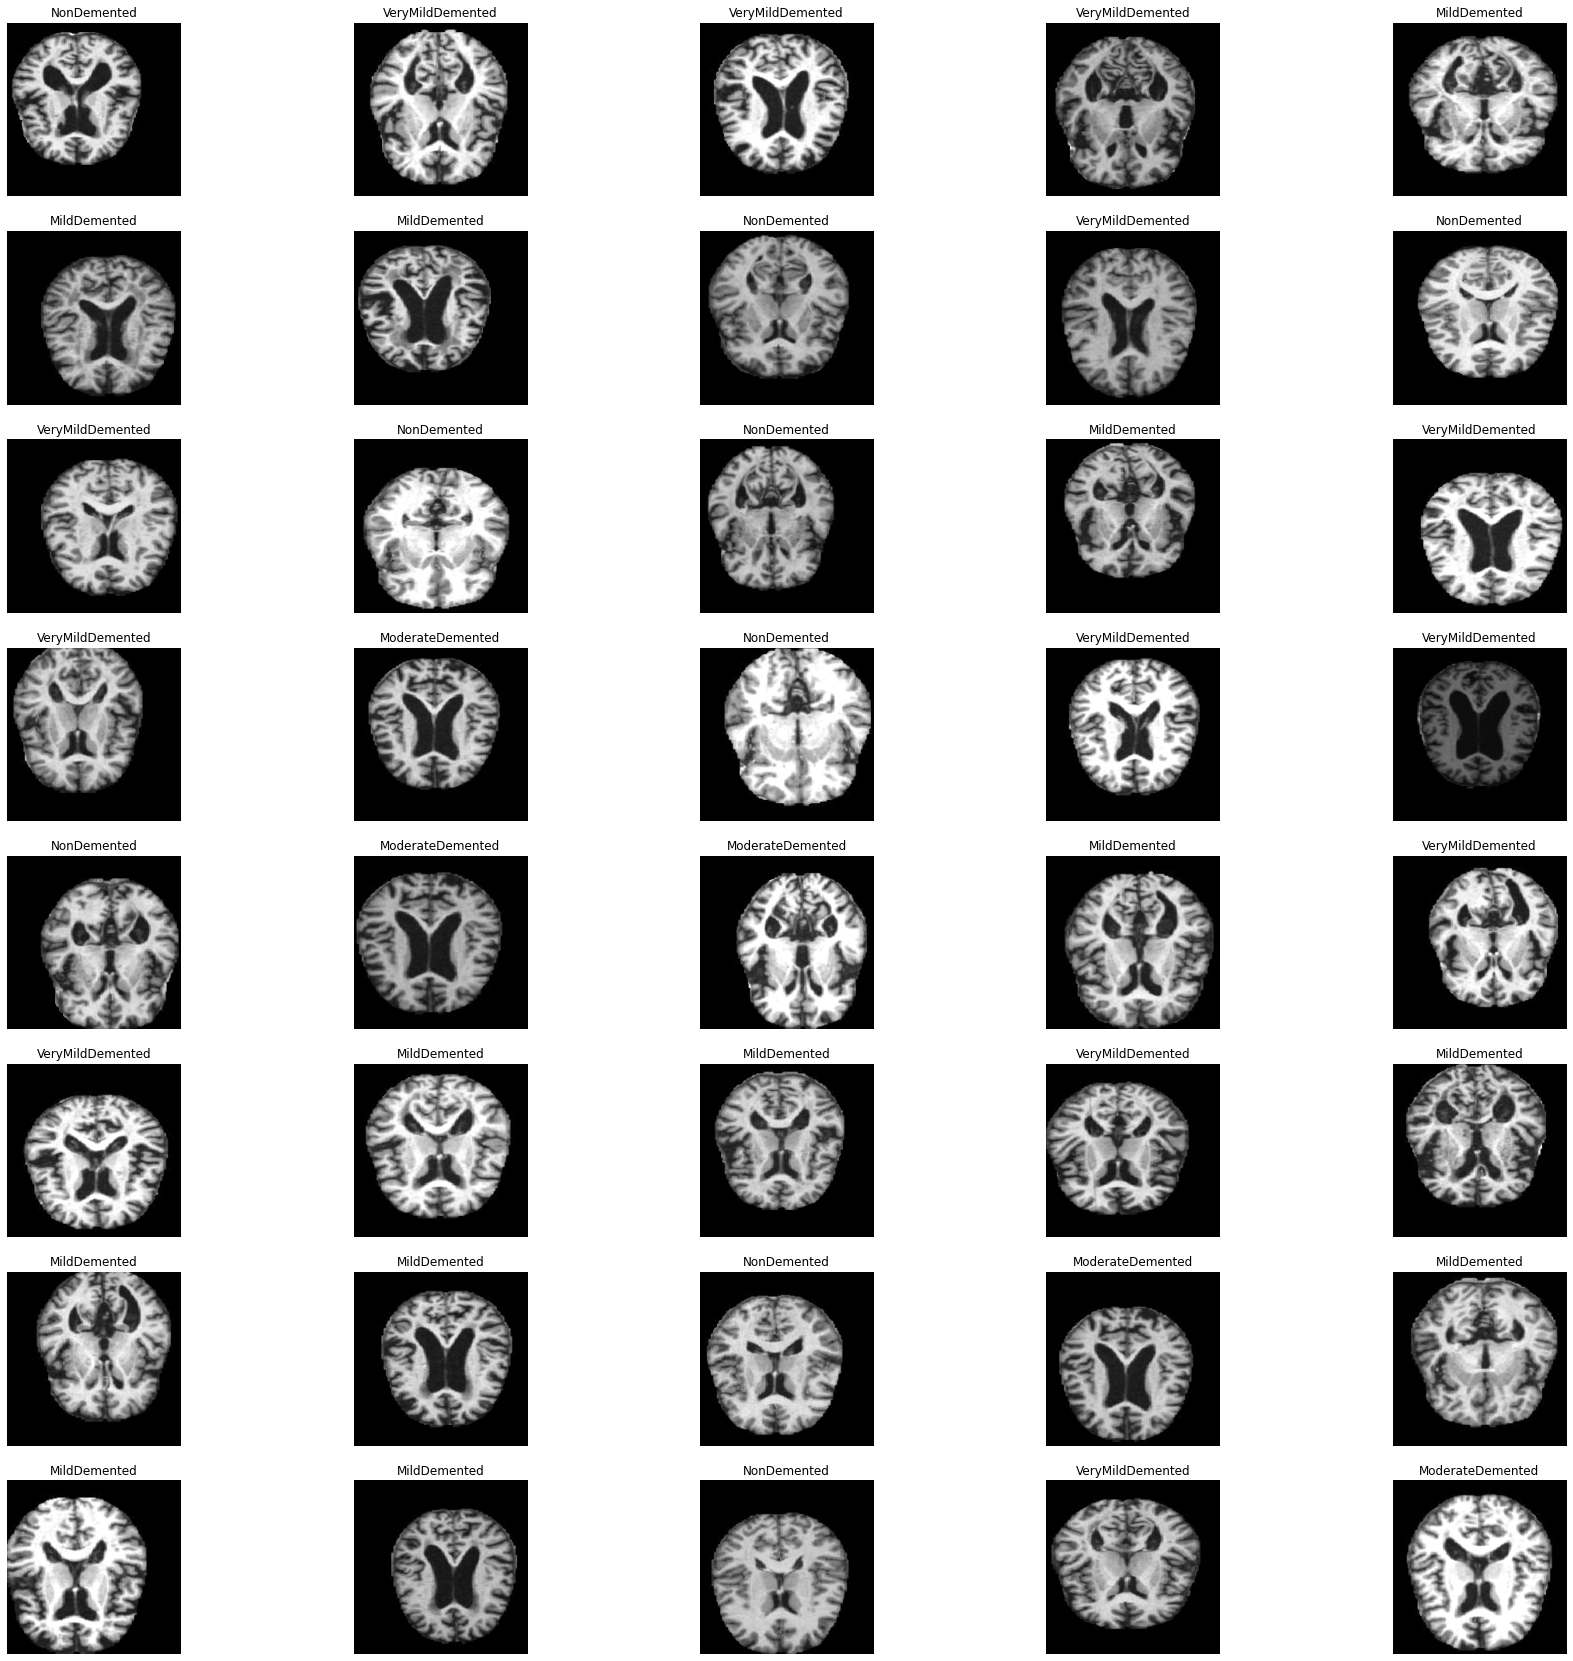

In [ ]:
if print_sample_input:
    display_input_images(train_generator, 2, batch_size, [8,5], [30,30])



In [ ]:
def build_model_cnn(regression_problem, conv_filters, conv_filter_shape, conv_activation_function, conv_padding, conv_pooling_type, conv_pooling_shape, hidden_layers_neurons, hidden_activation_function, L1_coeffs, L2_coeffs, hidden_layers_dropout, final_layer_neurons, final_activation_function, shape, model_optimizer, loss_function, metrics):

  model = models.Sequential()

    for i in range(len(conv_activation_function)):

        if (i == 0):
            model.add(layers.Conv2D(conv_filters[i],
                                    (conv_filter_shape[i][0],conv_filter_shape[i][1]),
                                    activation = conv_activation_function[i],
                                    padding    = conv_padding[i],
                                    input_shape = (shape[0],shape[1],shape[2])))
        else:
            model.add(layers.Conv2D(conv_filters[i],
                                    (conv_filter_shape[i][0],conv_filter_shape[i][1]),
                                    activation = conv_activation_function[i],
                                    padding    = conv_padding[i]))

        if (conv_pooling_type[i] == 'max'):
            model.add(layers.MaxPooling2D((conv_pooling_shape[i][0],conv_pooling_shape[i][1])))
        elif (conv_pooling_type[i] == 'avg'):
            model.add(layers.AveragePooling2D((conv_pooling_shape[i][0],conv_pooling_shape[i][1])))
        else:
            'no pooling'

    model.add(layers.Flatten())

    for i in range(len(hidden_activation_function)):

        model.add(layers.Dense(hidden_layers_neurons[i],
                               kernel_regularizer = regularizers.l1_l2(l1 = L1_coeffs[i], l2 =  L2_coeffs[i]),
                               activation=hidden_activation_function[i]))
        if (hidden_layers_dropout[i] > 0.0):
            model.add(layers.Dropout(hidden_layers_dropout[i]))
    if regression_problem:
            model.add(layers.Dense(final_layer_neurons))
    else:
            model.add(layers.Dense(final_layer_neurons,activation = final_activation_function))

    model.compile(optimizer = model_optimizer, loss = loss_function, metrics = metrics)

    model.summary()

    return model

In [ ]:
model = build_model_cnn(regression_problem, conv_filters, conv_filter_shape, conv_activation_function, conv_padding, conv_pooling_type, conv_pooling_shape, hidden_layers_neurons, hidden_activation_function,
                             hidden_layers_L1_coeffs, hidden_layers_L2_coeffs, hidden_layers_dropout, final_layer_neurons, final_activation_function, [target_img_shape_1, target_img_shape_2, target_img_channels],
                             model_optimizer, loss_function, metrics)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 128)       1

In [ ]:
early_exit      = EarlyStopping(monitor='val_loss', patience=15, verbose=0, mode='min')
best_checkpoint = ModelCheckpoint('.best_fit.hdf5', save_best_only=True, monitor='val_multiclass_AUC', mode='max')

hst = model.fit(train_generator, steps_per_epoch = train_generator.samples//batch_size, epochs = n_epochs, validation_data = validation_generator, validation_steps = validation_generator.samples//batch_size, callbacks =[early_exit, best_checkpoint])

model.load_weights(filepath = '.best_fit.hdf5')

Epoch 1/40
204/204 [==============================] - 132s 486ms/step - loss: 1.3861 - categorical_accuracy: 0.2888 - multiclass_AUC: 0.5453 - val_loss: 1.3972 - val_categorical_accuracy: 0.3870 - val_multiclass_AUC: 0.7388
Epoch 2/40
204/204 [==============================] - 98s 481ms/step - loss: 1.0752 - categorical_accuracy: 0.5221 - multiclass_AUC: 0.7689 - val_loss: 0.8350 - val_categorical_accuracy: 0.5920 - val_multiclass_AUC: 0.8282
Epoch 3/40
204/204 [==============================] - 98s 479ms/step - loss: 0.7932 - categorical_accuracy: 0.6324 - multiclass_AUC: 0.8525 - val_loss: 1.0176 - val_categorical_accuracy: 0.4920 - val_multiclass_AUC: 0.8438
Epoch 4/40
204/204 [==============================] - 98s 480ms/step - loss: 0.6540 - categorical_accuracy: 0.7019 - multiclass_AUC: 0.8938 - val_loss: 0.8050 - val_categorical_accuracy: 0.5990 - val_multiclass_AUC: 0.8750
Epoch 5/40
204/204 [==============================] - 98s 481ms/step - loss: 0.6090 - categorical_accuracy:

In [ ]:
def analyze_performances(hst, epochs):
    history_dict             = hst.history
    loss_values              = history_dict['loss']
    validation_loss_values   = history_dict['val_loss']
    acc_values               = history_dict['categorical_accuracy']
    validation_acc_values    = history_dict['val_categorical_accuracy']
    auc_values               = history_dict['multiclass_AUC']
    validation_auc_values    = history_dict['val_multiclass_AUC']
    epochs                   = range(1,len(loss_values) + 1)
    fig, axes                = plt.subplots(1,3,figsize = (30,10))
    training_ts              = [loss_values, acc_values, auc_values]
    validation_ts            = [validation_loss_values, validation_acc_values, validation_auc_values]
    metric_names             = ['loss', 'categorical accuracy','average multiclass AUC']
    for i in range(len(axes)):
        axes[i].plot(epochs,training_ts[i],color = 'r',label = 'training')
        axes[i].plot(epochs,validation_ts[i],color = 'b',label = 'validation')
        axes[i].set_xlabel('epoch')
        axes[i].set_ylabel(metric_names[i])
        axes[i].set_title(metric_names[i] + ' analysis')
        axes[i].set_xticks(np.arange(0,epochs[-1] + 1,5))
        axes[i].set_yticks(np.arange(0,1.1,0.1))
        axes[i].set_xlim([1,epochs[-1]])
        axes[i].set_ylim([np.min([np.min(training_ts[i]),np.min(validation_ts[i])]),np.max([np.max(training_ts[i]),np.max(validation_ts[i])])])
        axes[i].legend()
    plt.show()

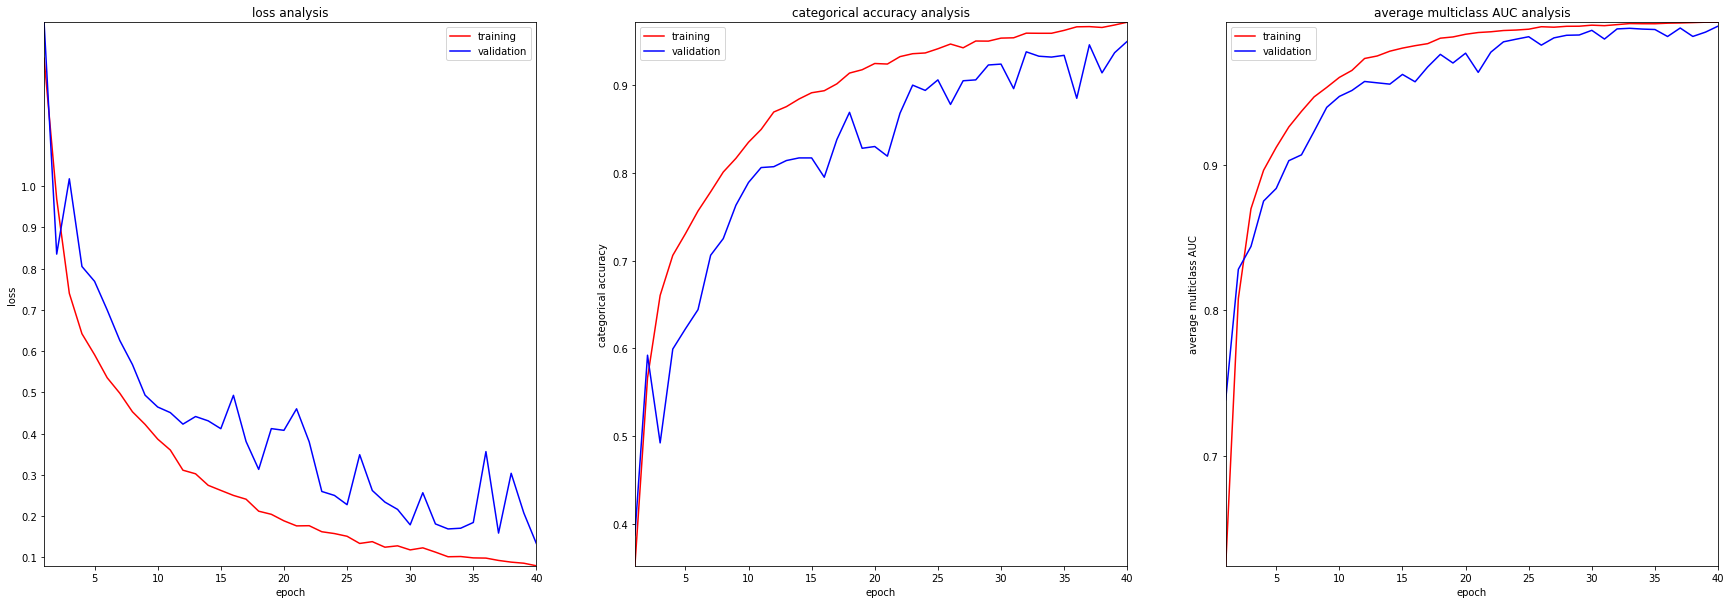

In [ ]:
analyze_performances(hst, n_epochs)

In [ ]:
def model_evaluation(model, test_generator):
    test_loss_1, test_acc_1, test_auc_1 = model.evaluate(test_generator, verbose=0)
    print('The value of the loss function on the test data set is: ' + str(round(test_loss_1,4)))
    print('The categorical accuracy of the predictions on the test data set is: ' + str(round(test_acc_1,4)))
    print('The categorical AUC (i.e., average curve across classes) of the predictions on the test data set is: ' + str(round(test_auc_1,4)))

    class_labels = list(test_generator.class_indices.keys())
    predictions = []
    true        = []
    ctr         = 0
    for batch, label in test_generator:
        prediction = model.predict(batch).argmax(axis = -1)
        predictions.extend(prediction)
        true.extend(label.argmax(axis = -1))
        ctr += len(prediction)
        if ctr >= len(test_generator.labels):
            break

    matrix     = confusion_matrix(true,predictions)
    rel_matrix = matrix/np.sum(matrix,axis = 0)
    fig, axes  = plt.subplots(1,2,figsize = (20,40))

    image1 = axes[0].imshow(matrix, cmap=plt.get_cmap('GnBu'))
    for (i, j), e in np.ndenumerate(matrix):
        axes[0].text(j, i, s = str(e), ha='center', va='center')
    axes[0].set_xticks(np.arange(0,len(class_labels), 1))
    axes[0].set_xticklabels(class_labels)
    axes[0].set_yticks(np.arange(0,len(class_labels), 1))
    axes[0].set_yticklabels(class_labels)
    axes[0].set_title('Confusion Matrix')

    image2 = axes[1].imshow(matrix/np.sum(matrix,axis = 0), cmap=plt.get_cmap('GnBu'))
    for (i, j), e in np.ndenumerate(rel_matrix):
        axes[1].text(j, i, s = str(np.round(e,2)), ha='center', va='center')
    axes[1].set_xticks(np.arange(0,len(class_labels), 1))
    axes[1].set_xticklabels(class_labels)
    axes[1].set_yticks(np.arange(0,len(class_labels), 1))
    axes[1].set_yticklabels(class_labels)
    plt.subplots_adjust(wspace = 0.5)
    axes[1].set_title('Confusion Matrix (Relative)')
    plt.show()

The value of the loss function on the test data set is: 0.9138
The categorical accuracy of the predictions on the test data set is: 0.717
The categorical AUC (i.e., average curve across classes) of the predictions on the test data set is: 0.8594


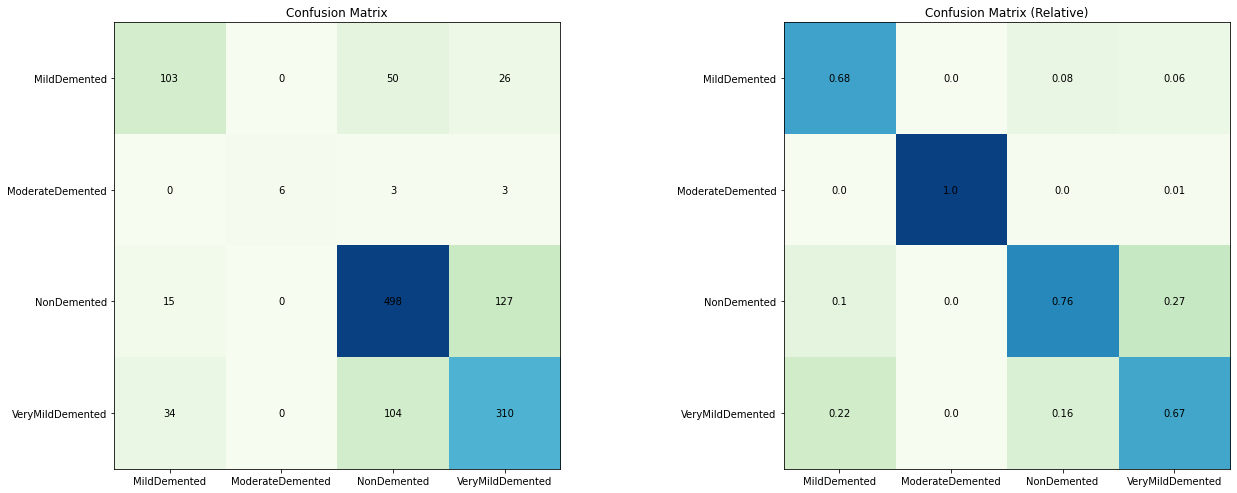

In [ ]:
model_evaluation(model, test_generator)